# NeurIPS UKBB Exploratory Data Analysis

## Setup 

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from env.imports import *

In [6]:
from models import *
from data import * 
from env import *
from sim import *

# data load
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome


### Paths and metadata

In [7]:
# Set paths
GeneEx2Conn_path = os.path.normpath(os.getcwd())
UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/'
print(GeneEx2Conn_path)
print(UKBB_path)

UKBB_demographics = pd.read_csv(UKBB_path + '/metadata/UKBB_MasterList_DemogInfo_part.csv')
unique_subject_ids = list(set([x.split('-')[1] for x in os.listdir(UKBB_path + '/XCP_D/') if x.startswith('sub-')]))
print(f"Number of scans: {len(unique_subject_ids)}")

with open(GeneEx2Conn_path + '/data/UKBB/UKBB_fMRI_subids.txt', 'r') as f:
    subjects_all = [line.strip() for line in f.readlines()]

with open(GeneEx2Conn_path + '/data/UKBB/UKBB_fMRI_subids_clean.txt', 'r') as f:
    subjects_clean = [line.strip() for line in f.readlines()]

print(f"Number of subjects with valid scans: {len(subjects_all)}")
print(f"Number of clean subjects: {len(subjects_clean)}")


schaef156_atlas_path = UKBB_path + '/atlases/atlas-4S156Parcels/atlas-4S156Parcels_dseg.tsv'
schaef156_atlas_info = pd.read_csv(schaef156_atlas_path, sep='\t')
schaef156_labels = schaef156_atlas_info['label'].tolist()

schaef456_atlas_path = UKBB_path + '/atlases/atlas-4S456Parcels/atlas-4S456Parcels_dseg.tsv'
schaef456_atlas_info = pd.read_csv(schaef456_atlas_path, sep='\t')
schaef456_labels = schaef456_atlas_info['label'].tolist()

schaef156_atlas_info.loc[schaef156_atlas_info['atlas_name'] == 'Cerebellum', 'network_label'] = 'Cerebellum'
schaef156_atlas_info.loc[(schaef156_atlas_info['network_label'].isna()) & 
                        (schaef156_atlas_info['atlas_name'] != 'Cerebellum'), 'network_label'] = 'Subcortical'

schaef456_atlas_info.loc[schaef456_atlas_info['atlas_name'] == 'Cerebellum', 'network_label'] = 'Cerebellum'
schaef456_atlas_info.loc[(schaef456_atlas_info['network_label'].isna()) & 
                        (schaef456_atlas_info['atlas_name'] != 'Cerebellum'), 'network_label'] = 'Subcortical'

schaef156_labels = schaef156_atlas_info['label'].tolist()
schaef156_network_labels = schaef156_atlas_info['network_label'].values
schaef456_labels = schaef456_atlas_info['label'].tolist()
schaef456_network_labels = schaef456_atlas_info['network_label'].values



/scratch/asr655/neuroinformatics/GeneEx2Conn
/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/
Number of scans: 1959
Number of subjects with valid scans: 1817
Number of clean subjects: 1501


## Load data

### Load all subjects and generate population average connectomes

In [8]:
def compute_UKBB_population_average_connectome(subject_list, data_path, atlas_name='156', verbose=True):
    """
    Compute population average connectome from a list of subjects.
    
    Parameters
    ----------
    subject_list : list
        List of subject IDs
    data_path : str
        Path to data directory
    atlas_name : str, optional
        Atlas to use ('156' or '456'), by default '156'
    verbose : bool, optional
        Whether to print progress, by default True
        
    Returns
    -------
    tuple
        (population average connectome matrix,
         number of subjects skipped,
         number of connectomes with NaN values)
    """
    # Validate atlas name
    atlas_str = '4S156Parcels' if atlas_name == '156' else '4S456Parcels' if atlas_name == '456' else None
    if not atlas_str:
        raise ValueError(f"Unsupported atlas_name: {atlas_name}")

    # Initialize list to store connectomes
    connectomes = []
    n_skipped = 0

    # Collect all valid connectomes
    for i, subject_id in enumerate(subject_list):
        if verbose and i % 100 == 0:
            print(f"Loading subject {i}/{len(subject_list)}")
            
        # Get subject path
        subject_dir = os.path.join(data_path, 'XCP_D', f'sub-{subject_id}')
        if not os.path.exists(subject_dir):
            n_skipped += 1
            continue
            
        # Get session
        session_dirs = [d for d in os.listdir(subject_dir) if d.startswith('ses-')]
        if not session_dirs:
            n_skipped += 1
            continue
            
        # Get connectome path
        relmat_path = os.path.join(subject_dir, session_dirs[0], 'func',
            f'sub-{subject_id}_{session_dirs[0]}_task-rest_space-MNI152NLin6Asym_seg-{atlas_str}_stat-pearsoncorrelation_relmat.tsv')
        
        try:
            # Load connectome
            curr_mat = pd.read_csv(relmat_path, sep='\t', header=None).values[1:, 1:].astype(float)
            connectomes.append(curr_mat)
        except Exception as e:
            if verbose: 
                print(f"Error processing subject {subject_id}: {str(e)}")
            n_skipped += 1
            continue

    # Count connectomes with NaN values
    nan_count = sum(np.any(np.isnan(conn)) for conn in connectomes)
    if verbose:
        print(f"Number of connectomes with NaN values: {nan_count} out of {len(connectomes)} total connectomes")

    # Compute average
    pop_avg = np.nanmean(connectomes, axis=0)
    # pop_avg = np.mean(connectomes, axis=0) # drops any region with NaN
    
    return pop_avg, connectomes

In [6]:
UKBB_S156_connectome_mu, S156_connectomes = compute_UKBB_population_average_connectome(
    subject_list=subjects_all,
    atlas_name='156',
    data_path=UKBB_path
)

Loading subject 0/1817
Loading subject 100/1817
Loading subject 200/1817
Error processing subject 1030376: [Errno 2] No such file or directory: '/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/XCP_D/sub-1030376/ses-20227/func/sub-1030376_ses-20227_task-rest_space-MNI152NLin6Asym_seg-4S156Parcels_stat-pearsoncorrelation_relmat.tsv'
Loading subject 300/1817
Error processing subject 1035201: [Errno 2] No such file or directory: '/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/XCP_D/sub-1035201/ses-20227/func/sub-1035201_ses-20227_task-rest_space-MNI152NLin6Asym_seg-4S156Parcels_stat-pearsoncorrelation_relmat.tsv'
Loading subject 400/1817
Loading subject 500/1817
Loading subject 600/1817
Loading subject 700/1817
Loading subject 800/1817
Loading subject 900/1817
Loading subject 1000/1817
Error processing subject 1135018: [Errno 2] No such file or directory: '/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/XCP_D/sub-1135018/ses-20227/func/su

In [9]:
UKBB_S456_connectome_mu, S456_connectomes = compute_UKBB_population_average_connectome(
    subject_list=subjects_all,
    atlas_name='456',
    data_path=UKBB_path
)

Loading subject 0/1817
Loading subject 100/1817
Loading subject 200/1817
Error processing subject 1030376: [Errno 2] No such file or directory: '/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/XCP_D/sub-1030376/ses-20227/func/sub-1030376_ses-20227_task-rest_space-MNI152NLin6Asym_seg-4S456Parcels_stat-pearsoncorrelation_relmat.tsv'
Loading subject 300/1817
Error processing subject 1035201: [Errno 2] No such file or directory: '/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/XCP_D/sub-1035201/ses-20227/func/sub-1035201_ses-20227_task-rest_space-MNI152NLin6Asym_seg-4S456Parcels_stat-pearsoncorrelation_relmat.tsv'
Loading subject 400/1817
Loading subject 500/1817
Loading subject 600/1817
Loading subject 700/1817
Loading subject 800/1817
Loading subject 900/1817
Loading subject 1000/1817
Error processing subject 1135018: [Errno 2] No such file or directory: '/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/XCP_D/sub-1135018/ses-20227/func/su

### Plot random connectomes

In [10]:
def plot_random_connectomes(connectomes, n_rows, max_rois):
    """
    Plot a grid of random connectomes from the dataset.
    
    Args:
        connectomes: List of connectome matrices
        n_rows: Number of rows/columns in the grid (total plots will be n_rows^2)
        max_rois: Maximum number of ROIs to show in each connectome plot
    """
    # Create a figure with n_rows x n_rows subplots
    fig, axes = plt.subplots(n_rows, n_rows, figsize=(2*n_rows, 2*n_rows))
    
    # Convert list to numpy array and get random indices
    connectome_array = np.array(connectomes)
    n_plots = n_rows * n_rows
    random_indices = np.random.choice(len(connectome_array), size=n_plots, replace=False)
    
    # Plot each connectome in the grid
    for idx, ax in enumerate(axes.flat):
        # Get random connectome and plot first max_rois x max_rois portion
        connectome = connectome_array[random_indices[idx]][:max_rois, :max_rois]
        im = ax.imshow(connectome, cmap='RdBu_r')
        ax.axis('off')  # Turn off axis labels
    
    # Add a colorbar that applies to all subplots
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    plt.suptitle(f'{n_plots} Random UKBB Cortical Connectomes (rsFC)', y=0.92)
    plt.show()

In [11]:
def plot_connectome_with_networks(connectome_mu, network_labels=None, n_rois=None, title=None):
    """
    Plot a connectome matrix with optional network labels and size limit.
    
    Args:
        connectome_mu: Average connectome matrix to plot
        network_labels: Optional list of network labels for each ROI
        n_rois: Optional number of ROIs to display (will show first n_rois x n_rois portion)
        title: Optional title for the plot. If None, uses default title.
    """
    plt.figure(figsize=(12, 10), dpi=200)
    
    # Limit connectome size if specified
    if n_rois is not None:
        connectome_mu = connectome_mu[:n_rois, :n_rois]
        if network_labels is not None:
            network_labels = network_labels[:n_rois]
    
    # Create the heatmap
    im = plt.imshow(connectome_mu, cmap='RdBu_r')
    plt.colorbar()

    if network_labels is not None:
        # Draw lines between different adjacent labels
        prev_label = network_labels[0]
        for i in range(1, len(network_labels)):
            if network_labels[i] != prev_label:
                plt.axhline(y=i-0.5, color='black', linewidth=0.5)
                plt.axvline(x=i-0.5, color='black', linewidth=0.5)
                prev_label = network_labels[i]
        
        # Create tick positions and labels
        tick_positions = []
        tick_labels = []
        start_idx = 0
        prev_label = network_labels[0]
        
        for i in range(1, len(network_labels)):
            if network_labels[i] != prev_label:
                tick_positions.append((start_idx + i - 1) / 2)
                tick_labels.append(prev_label)
                start_idx = i
                prev_label = network_labels[i]
        
        # Add the last group
        tick_positions.append((start_idx + len(network_labels) - 1) / 2)
        tick_labels.append(prev_label)

        plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
        plt.yticks(tick_positions, tick_labels)

    else:
        # Add numerical ticks every 20 ROIs (or 10 if total ROIs <= 100)
        total_rois = connectome_mu.shape[0]
        tick_interval = 20 if total_rois <= 200 else 50
        tick_positions = np.arange(0, total_rois, tick_interval)
        plt.xticks(tick_positions, tick_positions)
        plt.yticks(tick_positions, tick_positions)

    if title is None:
        title = 'Average Cortical Connectome (rsFC)'
    plt.title(title)
    plt.tight_layout()
    plt.show()


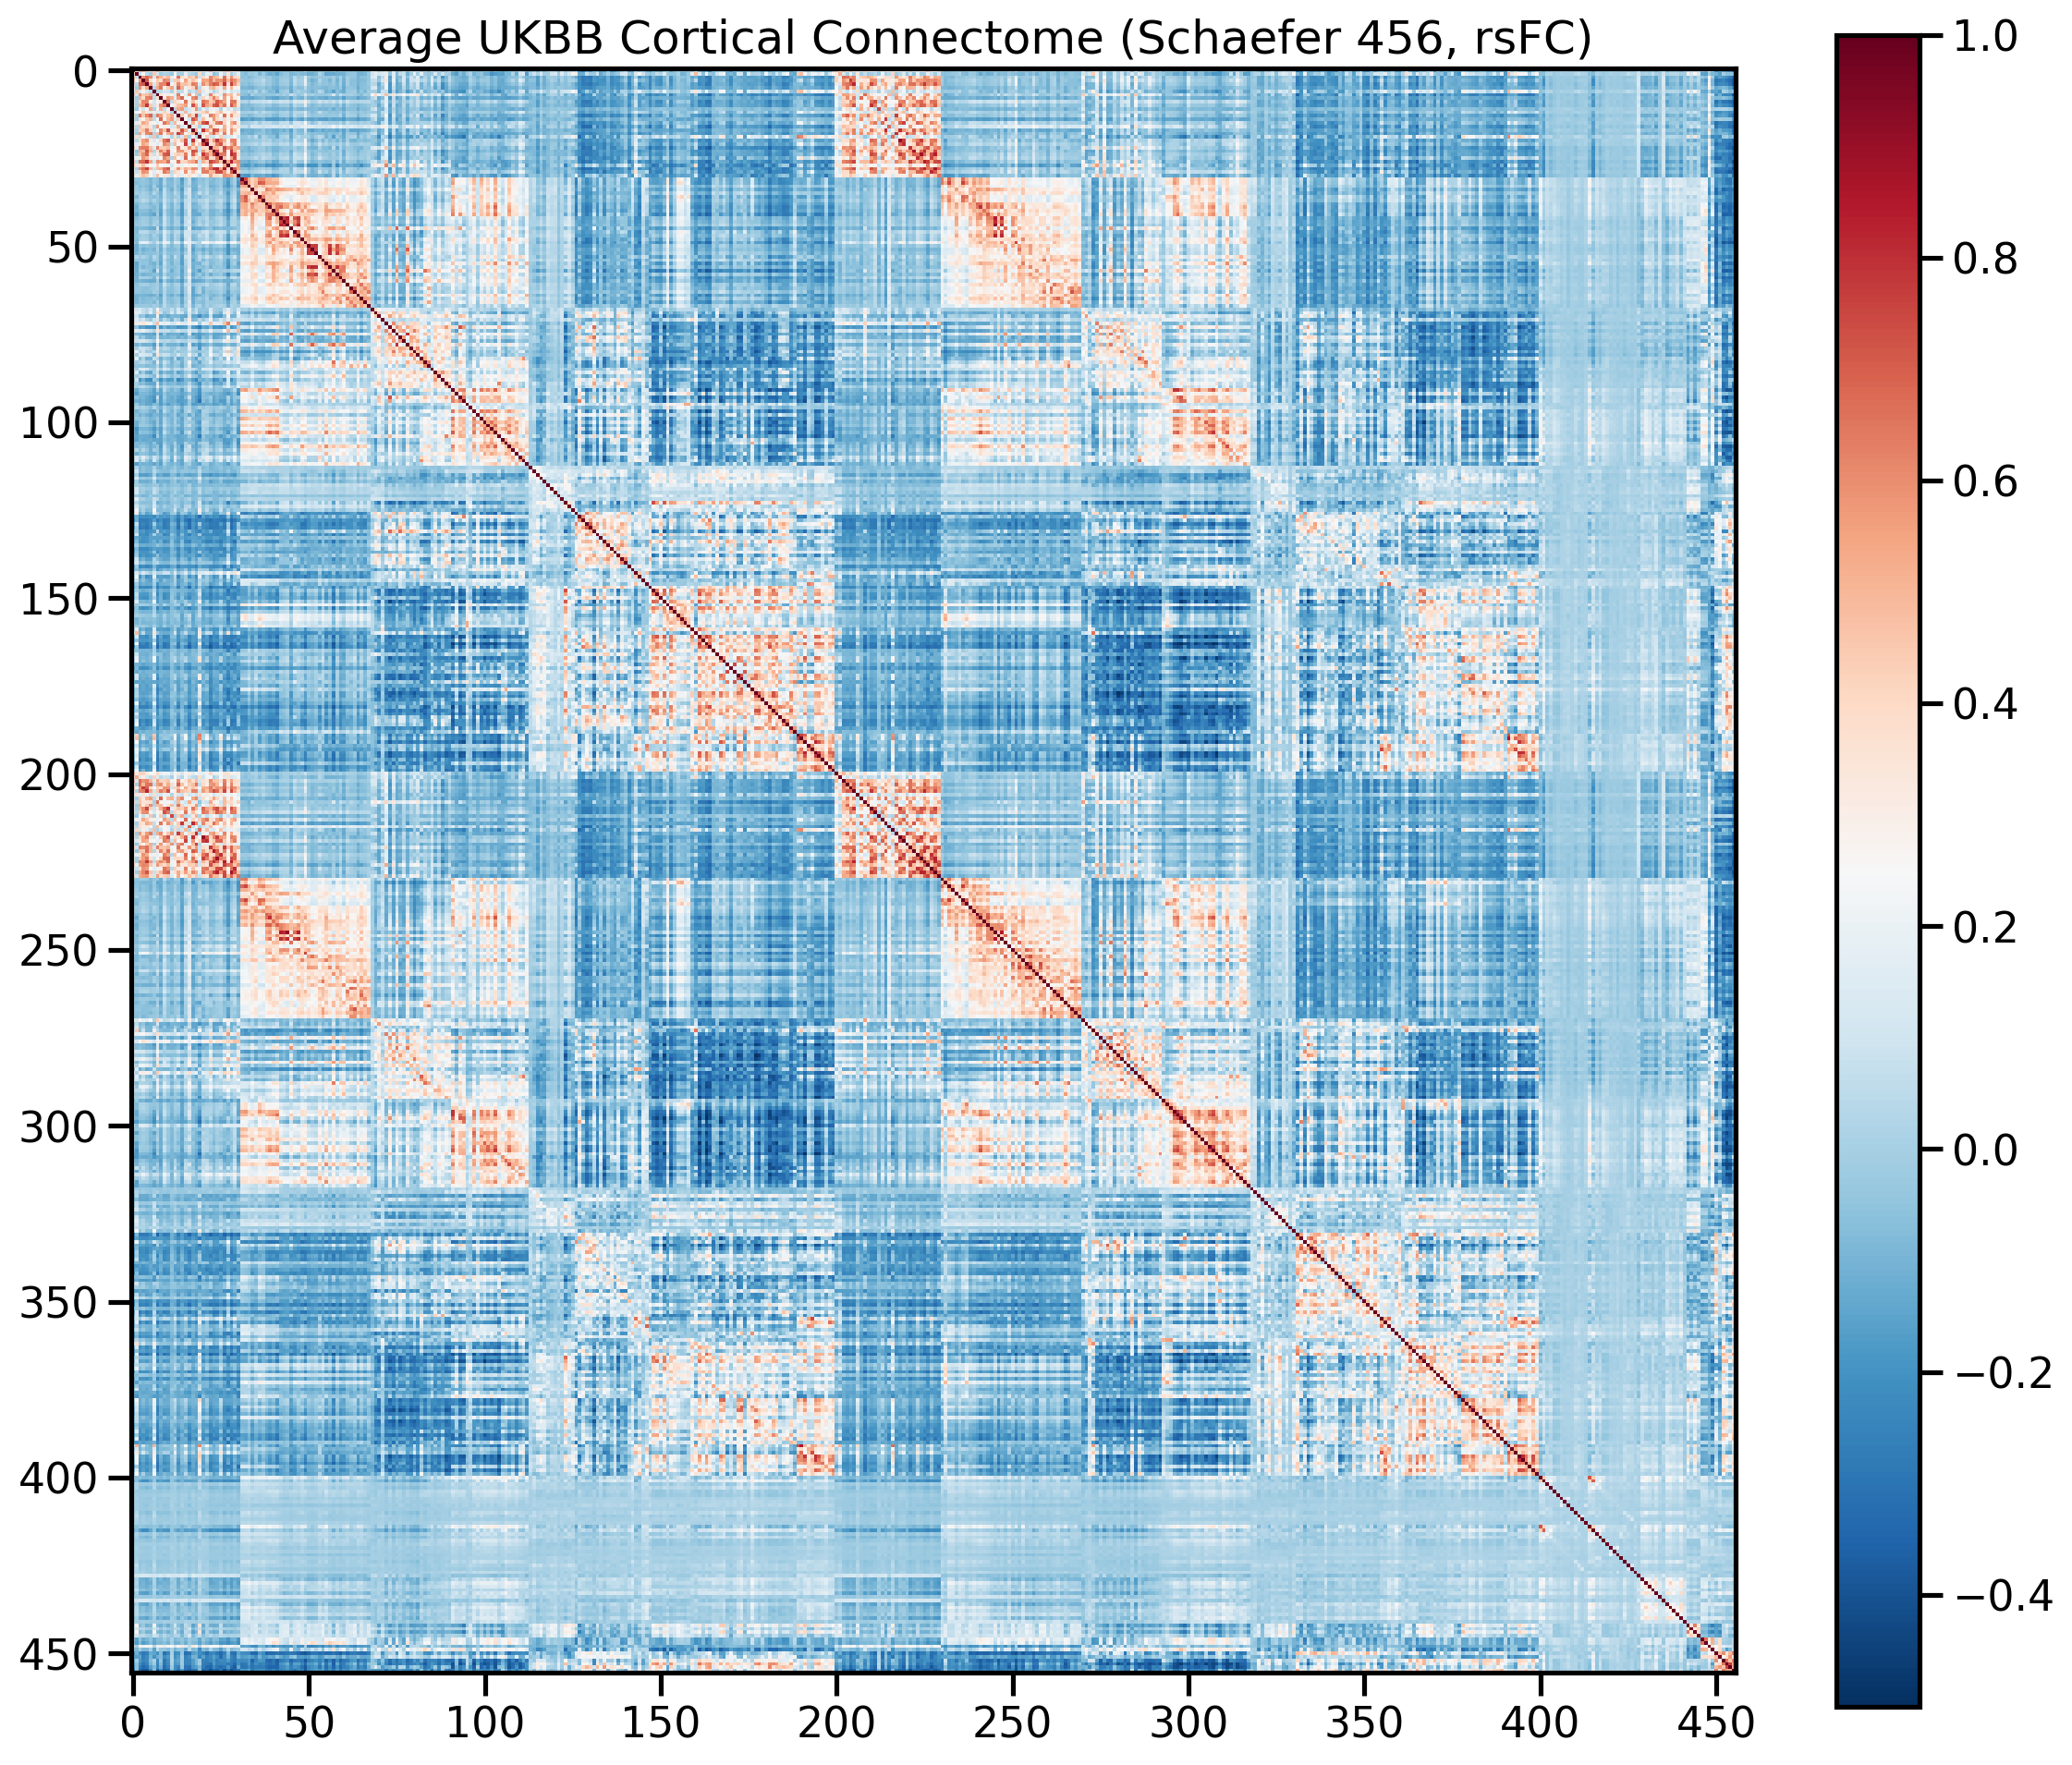

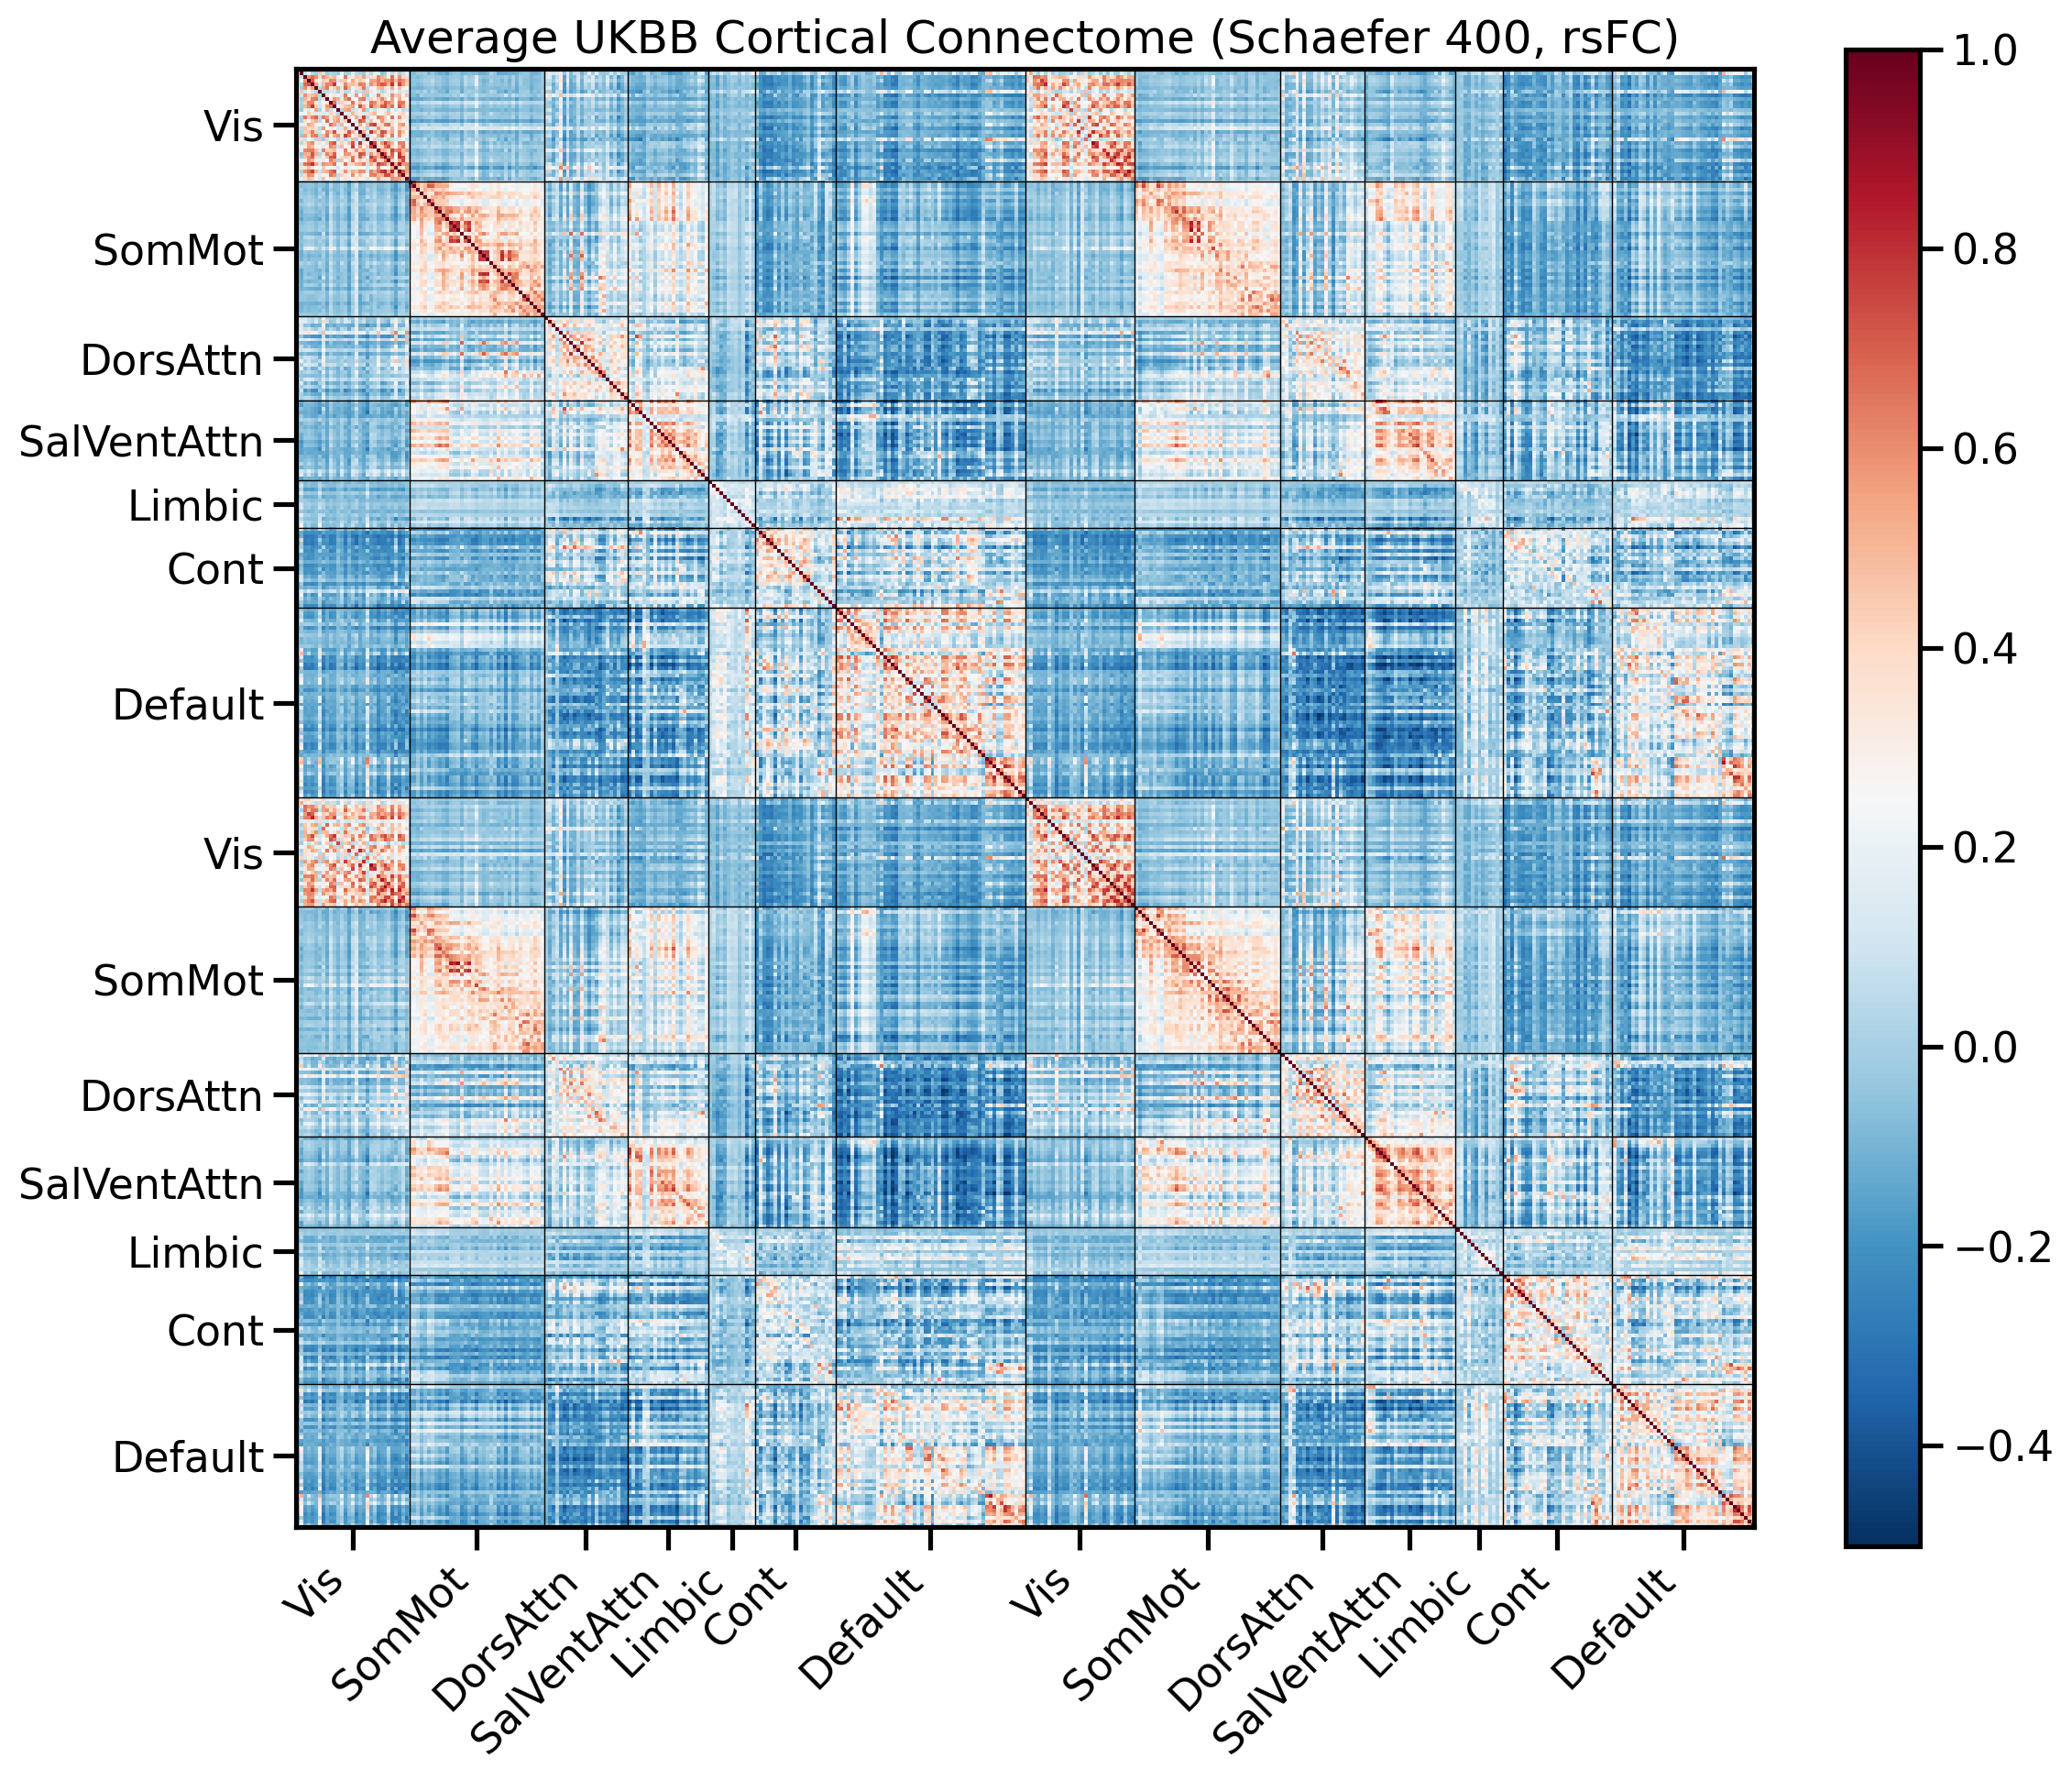

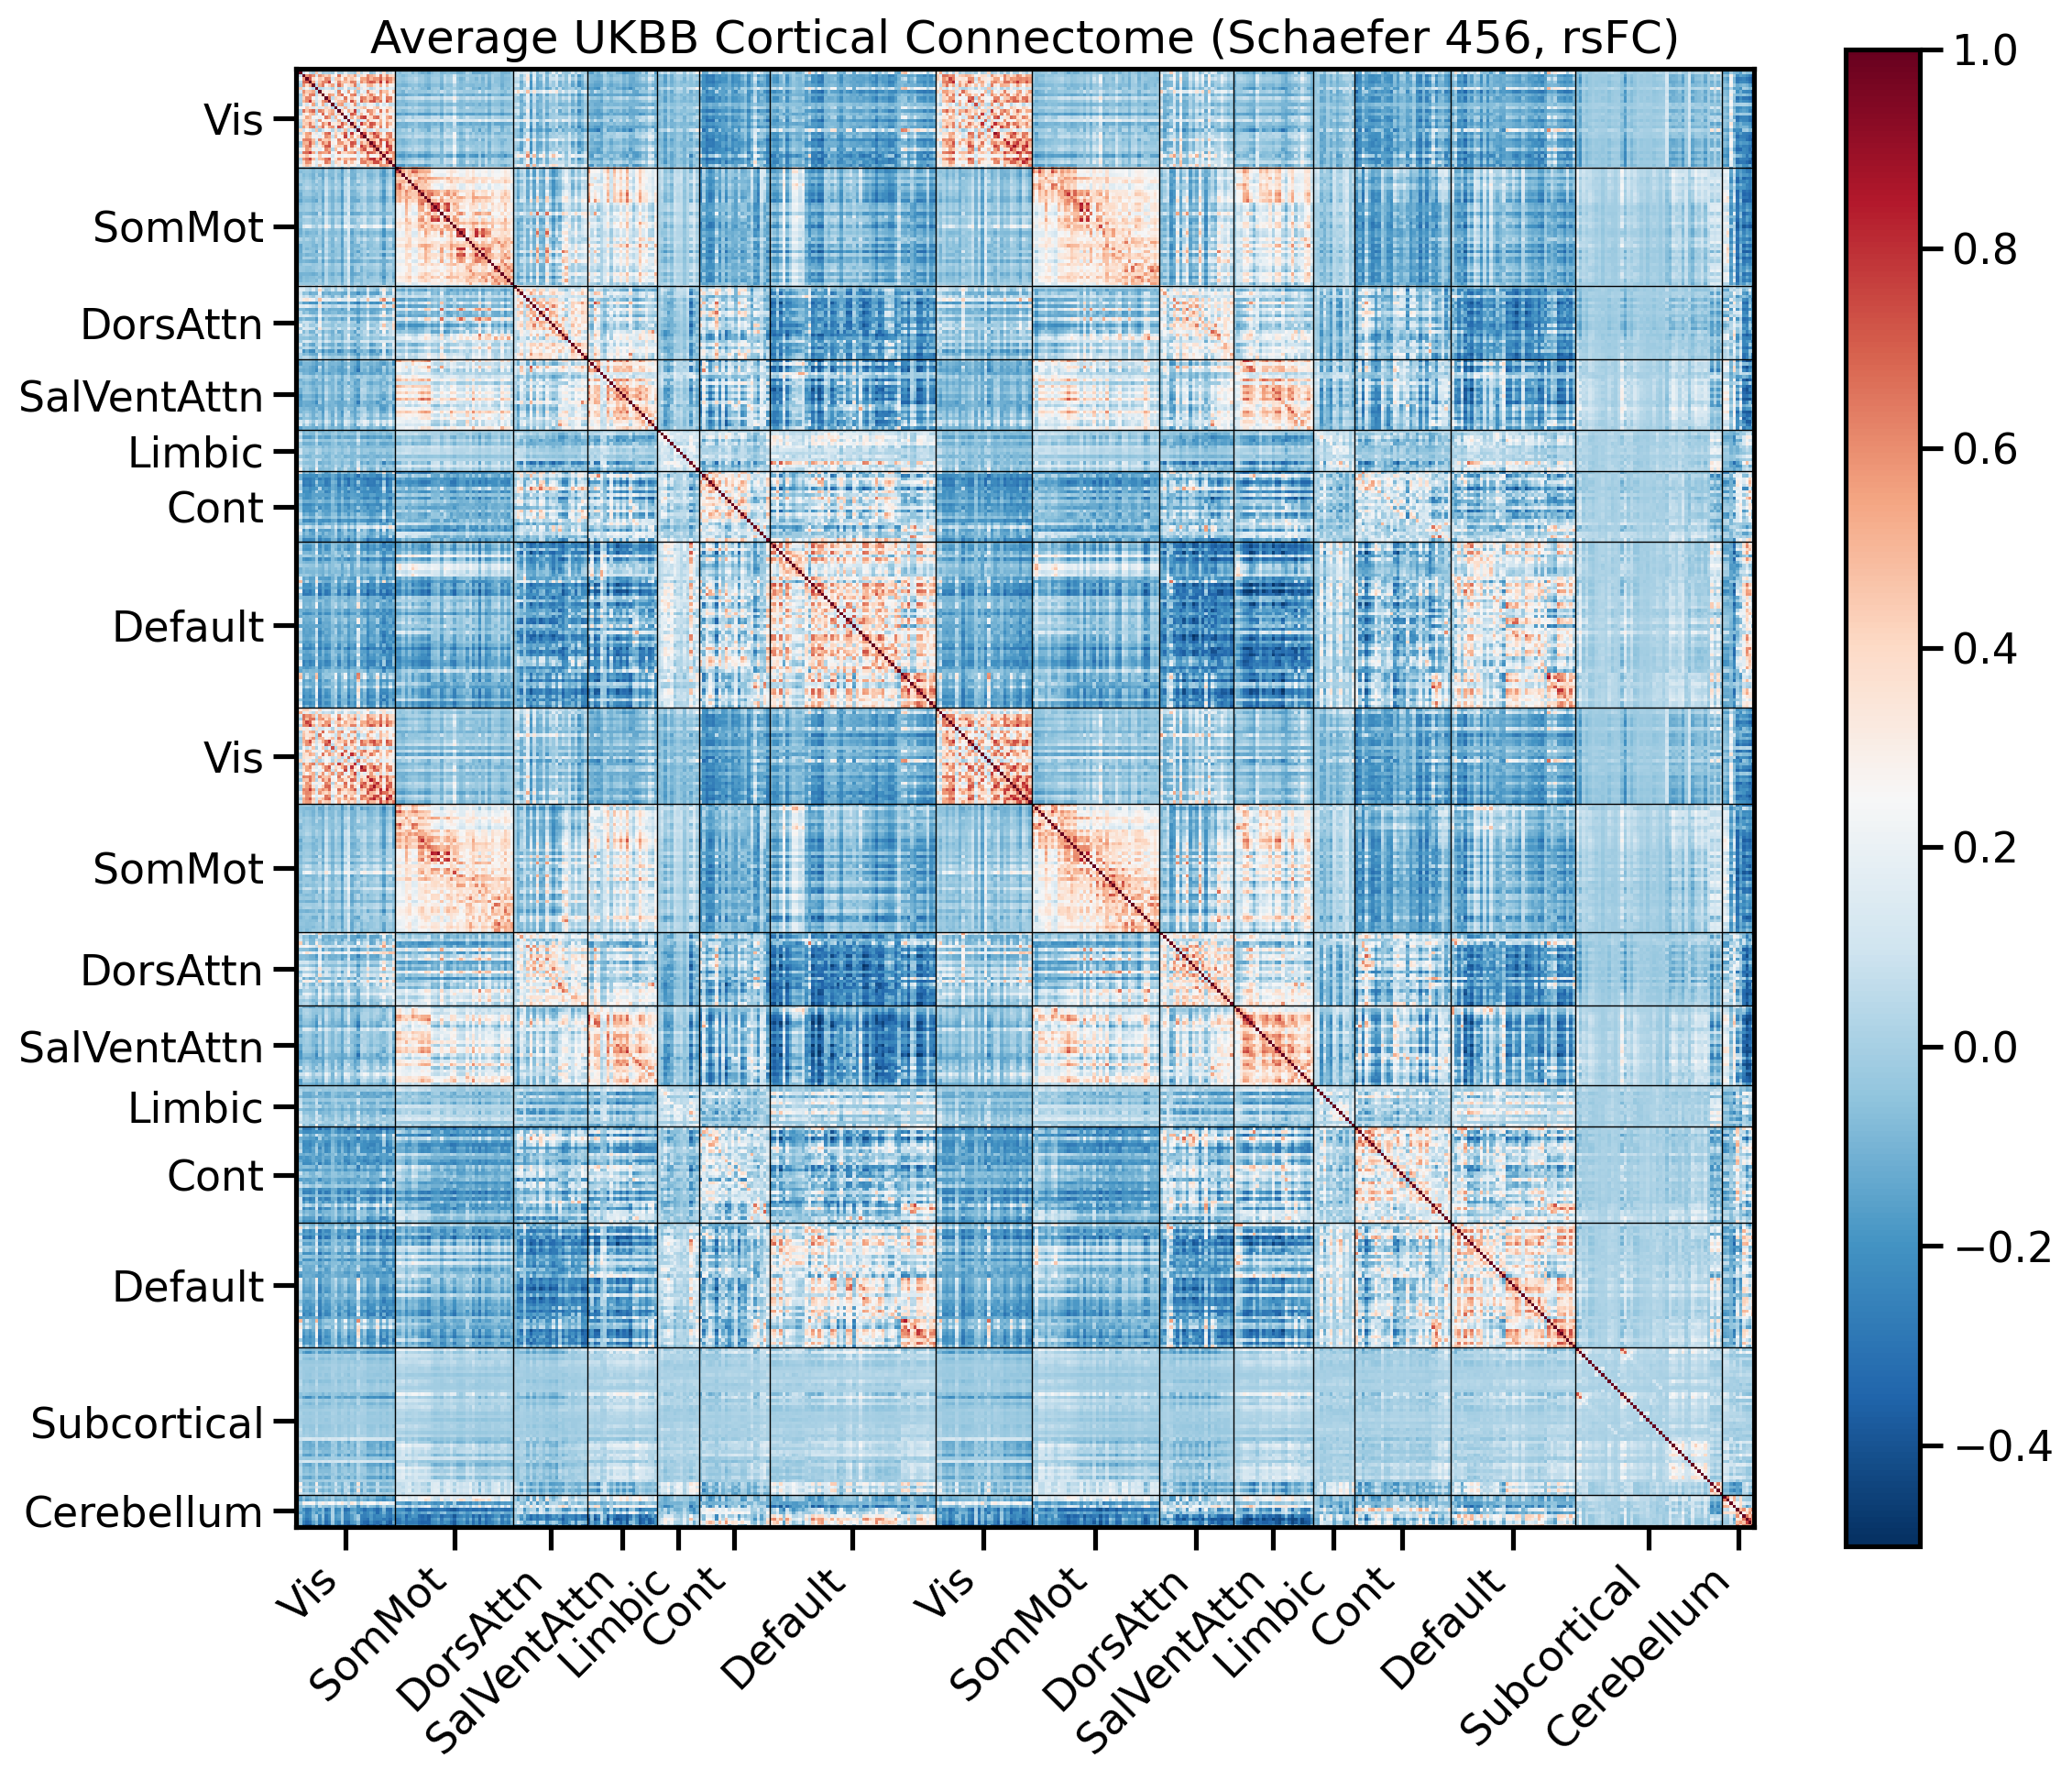

In [12]:
plot_connectome_with_networks(UKBB_S456_connectome_mu, network_labels=None, n_rois=456, title='Average UKBB Cortical Connectome (Schaefer 456, rsFC)')
plot_connectome_with_networks(UKBB_S456_connectome_mu, network_labels=schaef456_network_labels, n_rois=400, title='Average UKBB Cortical Connectome (Schaefer 400, rsFC)')
plot_connectome_with_networks(UKBB_S456_connectome_mu, network_labels=schaef456_network_labels, n_rois=456, title='Average UKBB Cortical Connectome (Schaefer 456, rsFC)')


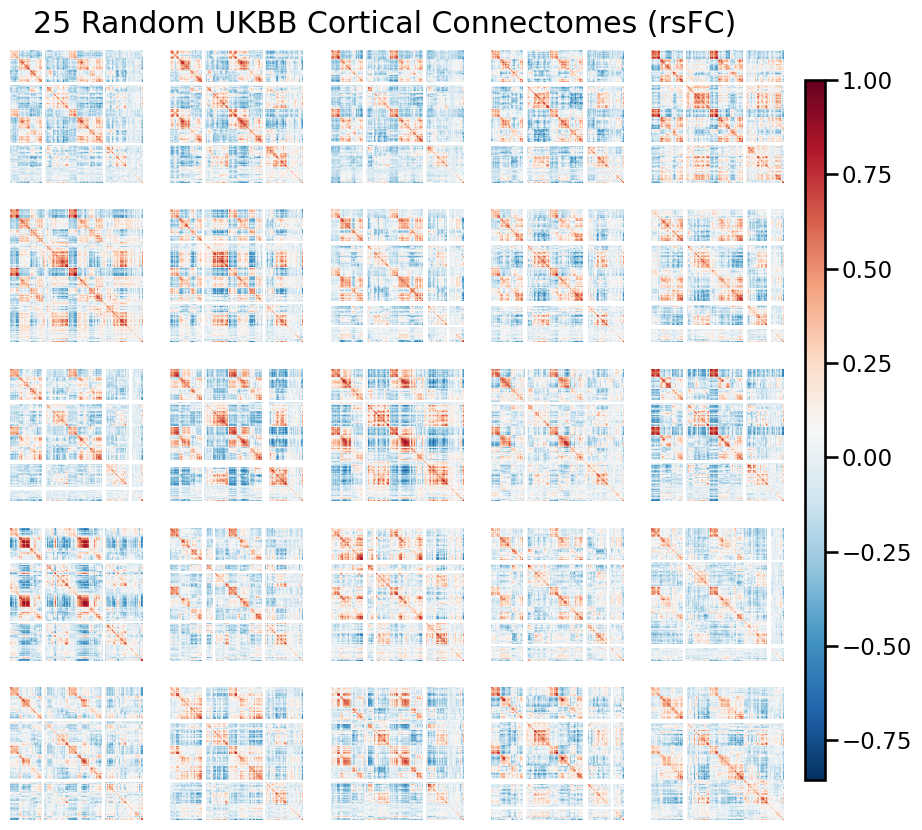

In [13]:
plot_random_connectomes(S456_connectomes, n_rows=5, max_rois=456)

### Residuals

In [14]:
def compute_connectome_residuals(individual_connectomes, population_average, n_regions=None):
    """
    Compute residuals between individual connectomes and population average.
    
    Parameters:
    -----------
    individual_connectomes : list
        List of individual connectivity matrices
    population_average : numpy.ndarray 
        Population average connectivity matrix
    n_regions : int, optional
        Number of regions to include in analysis. If None, uses all regions (default None)
        
    Returns:
    --------
    numpy.ndarray
        1D array of flattened residuals
    """
    # Get max number of regions from population average shape
    max_regions = population_average.shape[0]
    
    # Use all regions if n_regions not specified or is larger than max
    n_regions = min(n_regions, max_regions) if n_regions is not None else max_regions
    
    # Select subset of regions
    subset_connectomes = [conn[:n_regions, :n_regions] for conn in individual_connectomes]
    pop_avg_subset = population_average[:n_regions, :n_regions]
    
    print(f"Original connectome shape: {individual_connectomes[0].shape}")
    print(f"Subset connectome shape: {subset_connectomes[0].shape}")

    # Convert to numpy array and compute residuals
    connectome_array = np.array(subset_connectomes)
    residuals = connectome_array - pop_avg_subset

    # Flatten residuals into 1D array
    return residuals.flatten()

def plot_residual_distribution(all_residuals):
    """
    Plot distribution of residuals between individual connectomes and population average.
    Tests and visualizes if the distribution is Gaussian.
    
    Parameters:
    -----------
    all_residuals : numpy.ndarray
        1D array of flattened residuals
    """
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot histogram without KDE
    sns.histplot(all_residuals, kde=False, stat='density', bins=100)
    
    # Fit normal distribution and plot
    mu, std = np.nanmean(all_residuals), np.nanstd(all_residuals)
    
    plt.title('Distribution of Residuals All Connectomes vs. Population Average')
    plt.xlabel('Residual Value')
    plt.ylabel('Density')
    plt.legend()
    
    # Perform Shapiro-Wilk test for normality
    statistic, p_value = stats.shapiro(all_residuals[~np.isnan(all_residuals)])
    
    # Add summary statistics and normality test results as text
    stats_text = f'Mean: {mu:.3f}\n'
    stats_text += f'Std: {std:.3f}\n'
    
    stats_text += f'\nShapiro-Wilk Test:\n'
    stats_text += f'Statistic: {statistic:.3f}\n'
    stats_text += f'p-value: {p_value:.3e}\n'
    stats_text += f'Distribution is {"Normal" if p_value > 0.05 else "Not Normal"}'
    
    plt.text(0.95, 0.95, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()

In [15]:
#all_S156_residuals = compute_connectome_residuals(S156_connectomes, UKBB_S156_connectome_mu)
all_S456_residuals = compute_connectome_residuals(S456_connectomes, UKBB_S456_connectome_mu)

Original connectome shape: (456, 456)
Subset connectome shape: (456, 456)


  warnings.warn("p-value may not be accurate for N > 5000.")



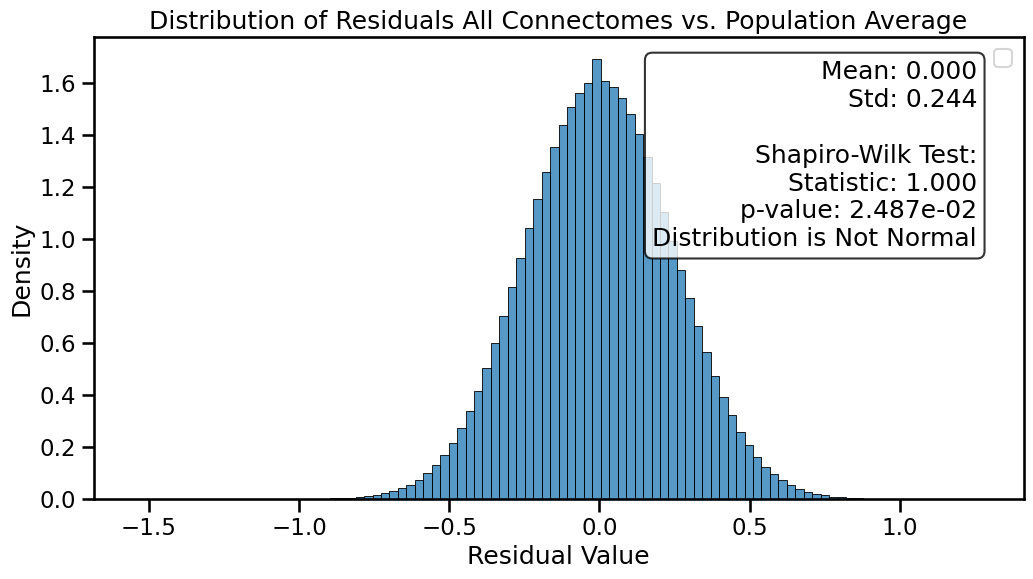

In [16]:
plot_residual_distribution(all_S456_residuals)

### Connectome subset KDEs

In [17]:
def plot_edge_distributions(connectomes, starting_roi, next_rois, avg_connectome):
    """
    Plot KDE distributions for all edges in the upper triangle of the connectome.
    
    Parameters:
    -----------
    connectomes : list
        List of connectivity matrices
    starting_roi : int
        Starting ROI index (0-based)
    next_rois : int
        Number of subsequent ROIs to plot
    avg_connectome : numpy.ndarray
        Population average connectome matrix
    """
    # Convert to numpy array and subset
    connectome_array = np.array(connectomes)
    n_subjects = len(connectome_array)
    
    # Calculate ending ROI index
    end_roi = starting_roi + next_rois
    
    # First plot the subsetted connectome
    subset_connectome = avg_connectome[starting_roi:end_roi, starting_roi:end_roi]
    
    # Create mask for upper triangle
    mask = np.tril(np.ones_like(subset_connectome))
    
    # Create masked array
    masked_connectome = np.ma.array(subset_connectome, mask=mask)
    
    plt.figure(figsize=(12, 10), dpi=200)
    plt.imshow(masked_connectome, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
    plt.colorbar()
    plt.title(f'Average Cortical Connectome Subset (ROIs {starting_roi}-{end_roi-1})')
    
    # Set integer ticks
    plt.xticks(range(0, next_rois, 5), range(starting_roi, end_roi, 5))
    plt.yticks(range(0, next_rois, 5), range(starting_roi, end_roi, 5))
    
    plt.show()
    
    # KDE part
    # Create figure with subplots for upper triangle
    n_rows = next_rois - 1
    n_cols = next_rois - 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 24))  # Made height equal to width
    
    # Get max possible range from population average for consistent scaling
    max_abs_val = np.max(np.abs(avg_connectome))
    x_range = (-max_abs_val, max_abs_val)
    
    # Plot KDE for each edge in upper triangle
    plot_idx = 0
    for i in range(starting_roi, end_roi):
        for j in range(i+1, end_roi):
            # Get row and column index in subplot grid
            row = i - starting_roi
            col = j - starting_roi - 1
            
            # Get distribution of values for this edge across subjects
            edge_values = connectome_array[:, i, j]
            
            # Get average value for background color
            avg_value = avg_connectome[i, j]
            
            # Set background color based on average value
            axes[row, col].set_facecolor(plt.cm.RdBu_r((avg_value + 1) / 2))
            
            # Plot KDE with thicker lines and black border
            sns.kdeplot(edge_values, ax=axes[row, col], color='black', linewidth=5)  # Increased from 3 to 5
            axes[row, col].spines['top'].set_visible(True)
            axes[row, col].spines['right'].set_visible(True)
            axes[row, col].spines['bottom'].set_visible(True)
            axes[row, col].spines['left'].set_visible(True)
            axes[row, col].spines['top'].set_color('black')
            axes[row, col].spines['right'].set_color('black')
            axes[row, col].spines['bottom'].set_color('black')
            axes[row, col].spines['left'].set_color('black')
            axes[row, col].spines['top'].set_linewidth(2)
            axes[row, col].spines['right'].set_linewidth(2)
            axes[row, col].spines['bottom'].set_linewidth(2)
            axes[row, col].spines['left'].set_linewidth(2)
            axes[row, col].set_xlim(x_range)
            
            # Make subplot square by setting aspect ratio to 'equal'
            axes[row, col].set_aspect(1.0/axes[row, col].get_data_ratio())
            
            # Add vertical line for population average with thicker line
            axes[row, col].axvline(x=avg_value, color='blue', linestyle='--', linewidth=5)  # Increased from 3 to 5
            
            # Remove all labels and ticks
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            axes[row, col].set_xlabel('')
            axes[row, col].set_ylabel('')
            
            plot_idx += 1
    
    # Remove empty subplots in lower triangle
    for i in range(n_rows):
        for j in range(n_cols):
            if j <= i:
                axes[i,j].remove()
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

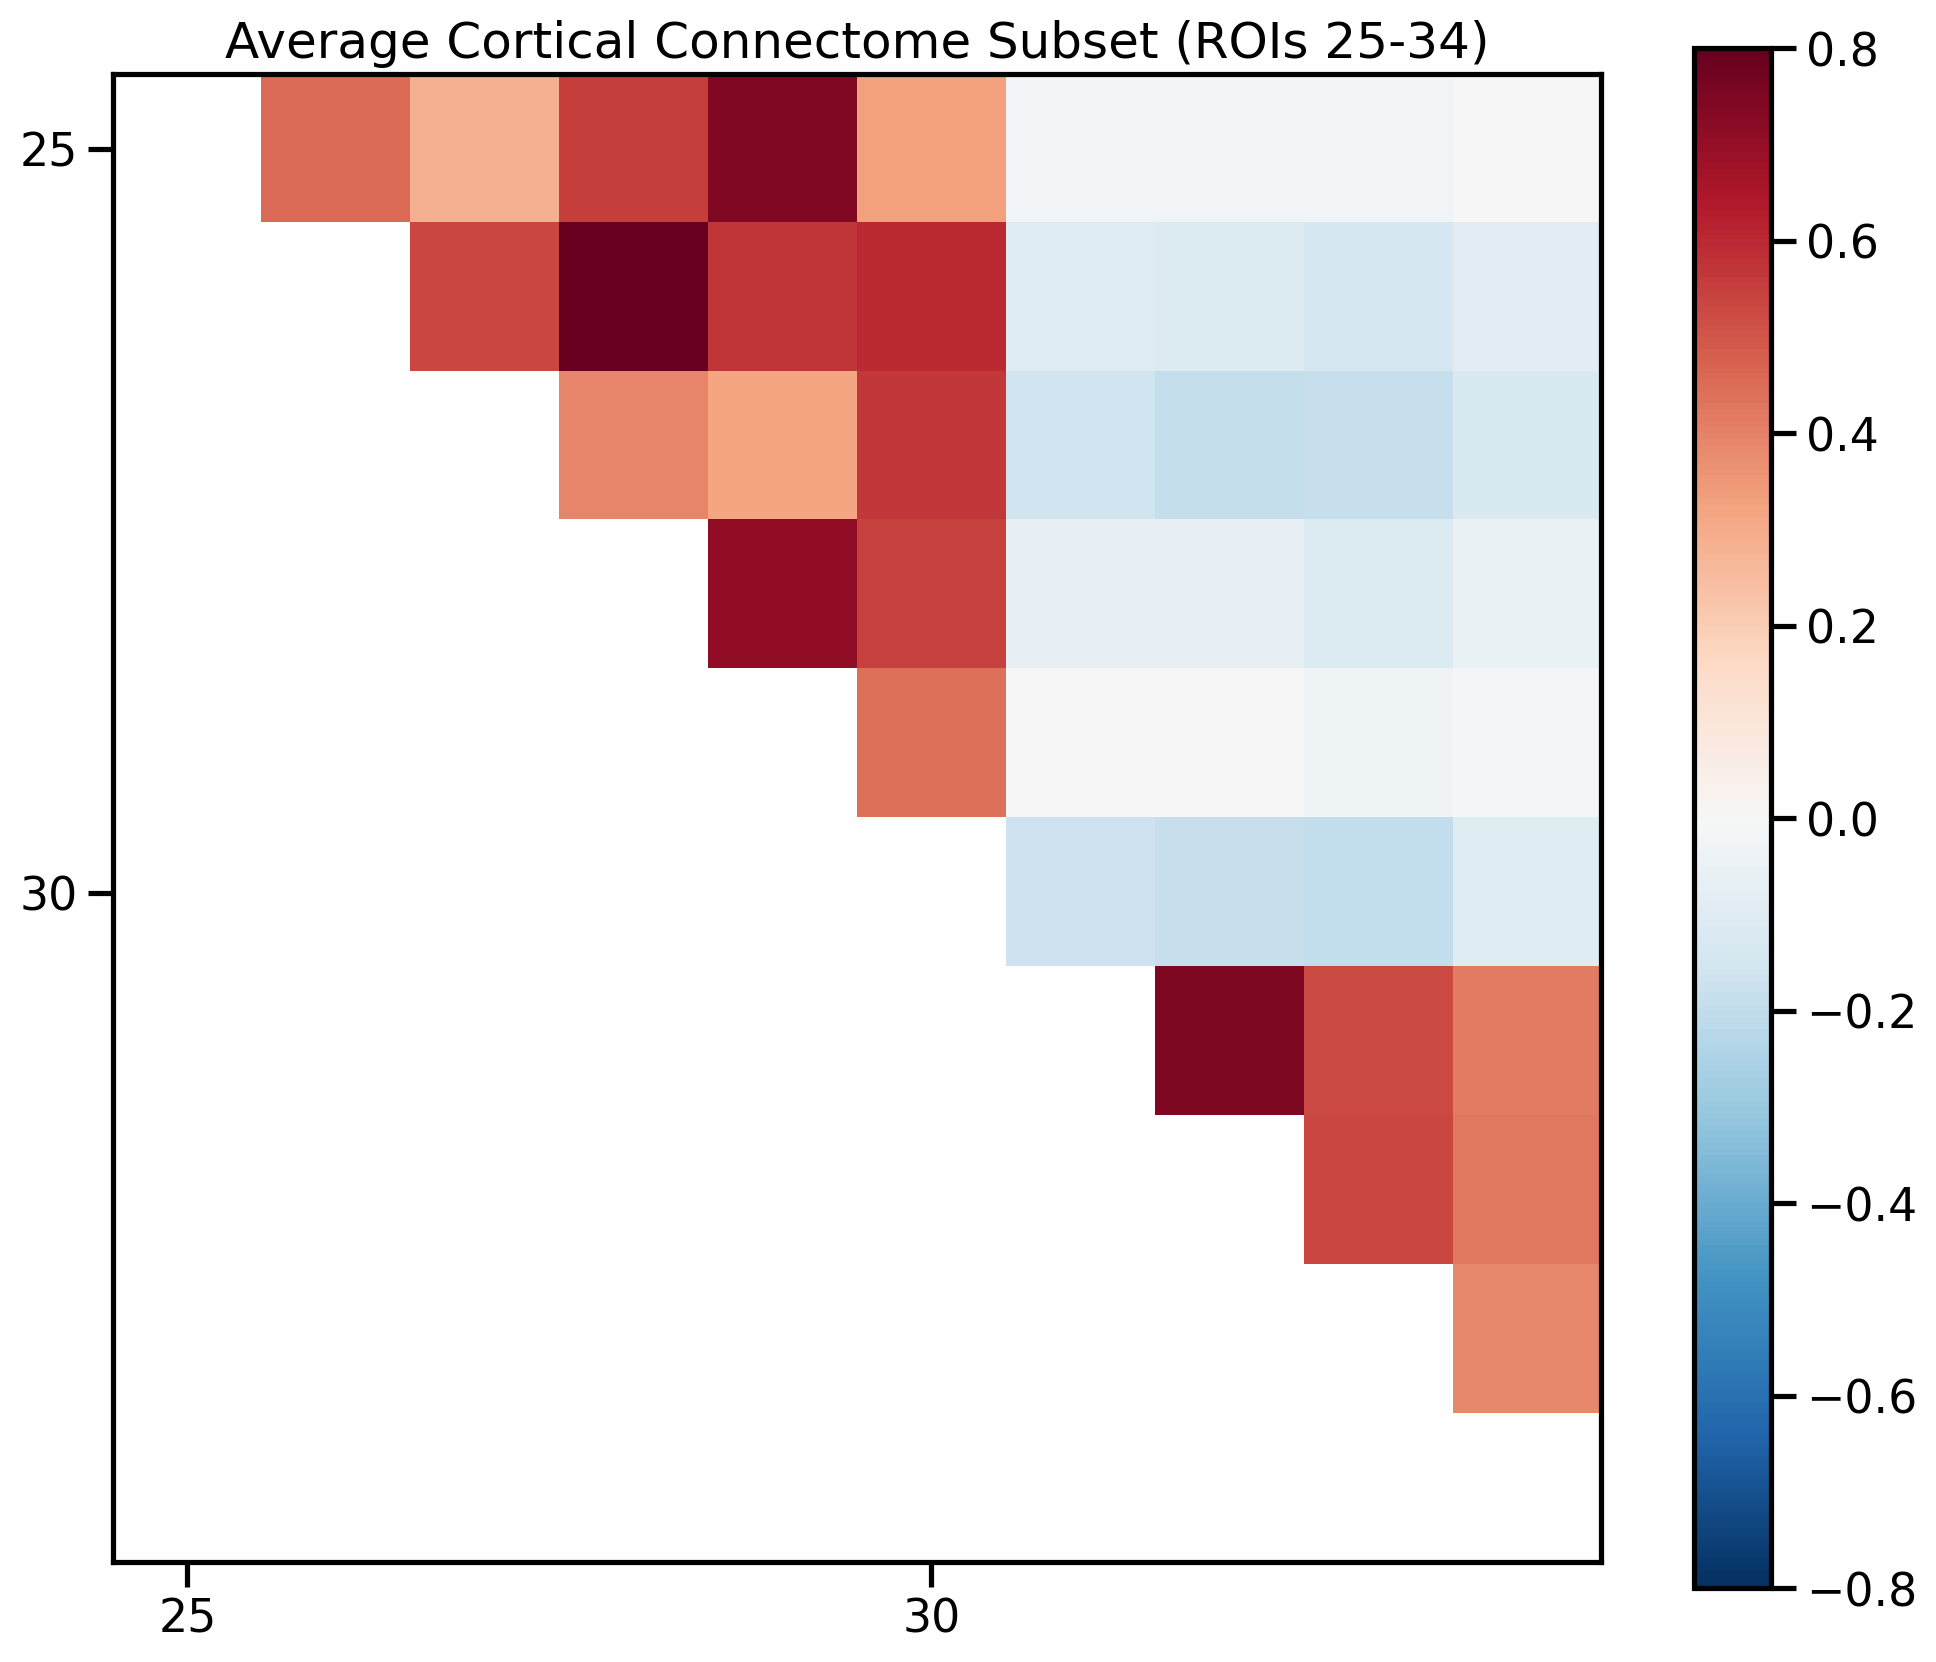

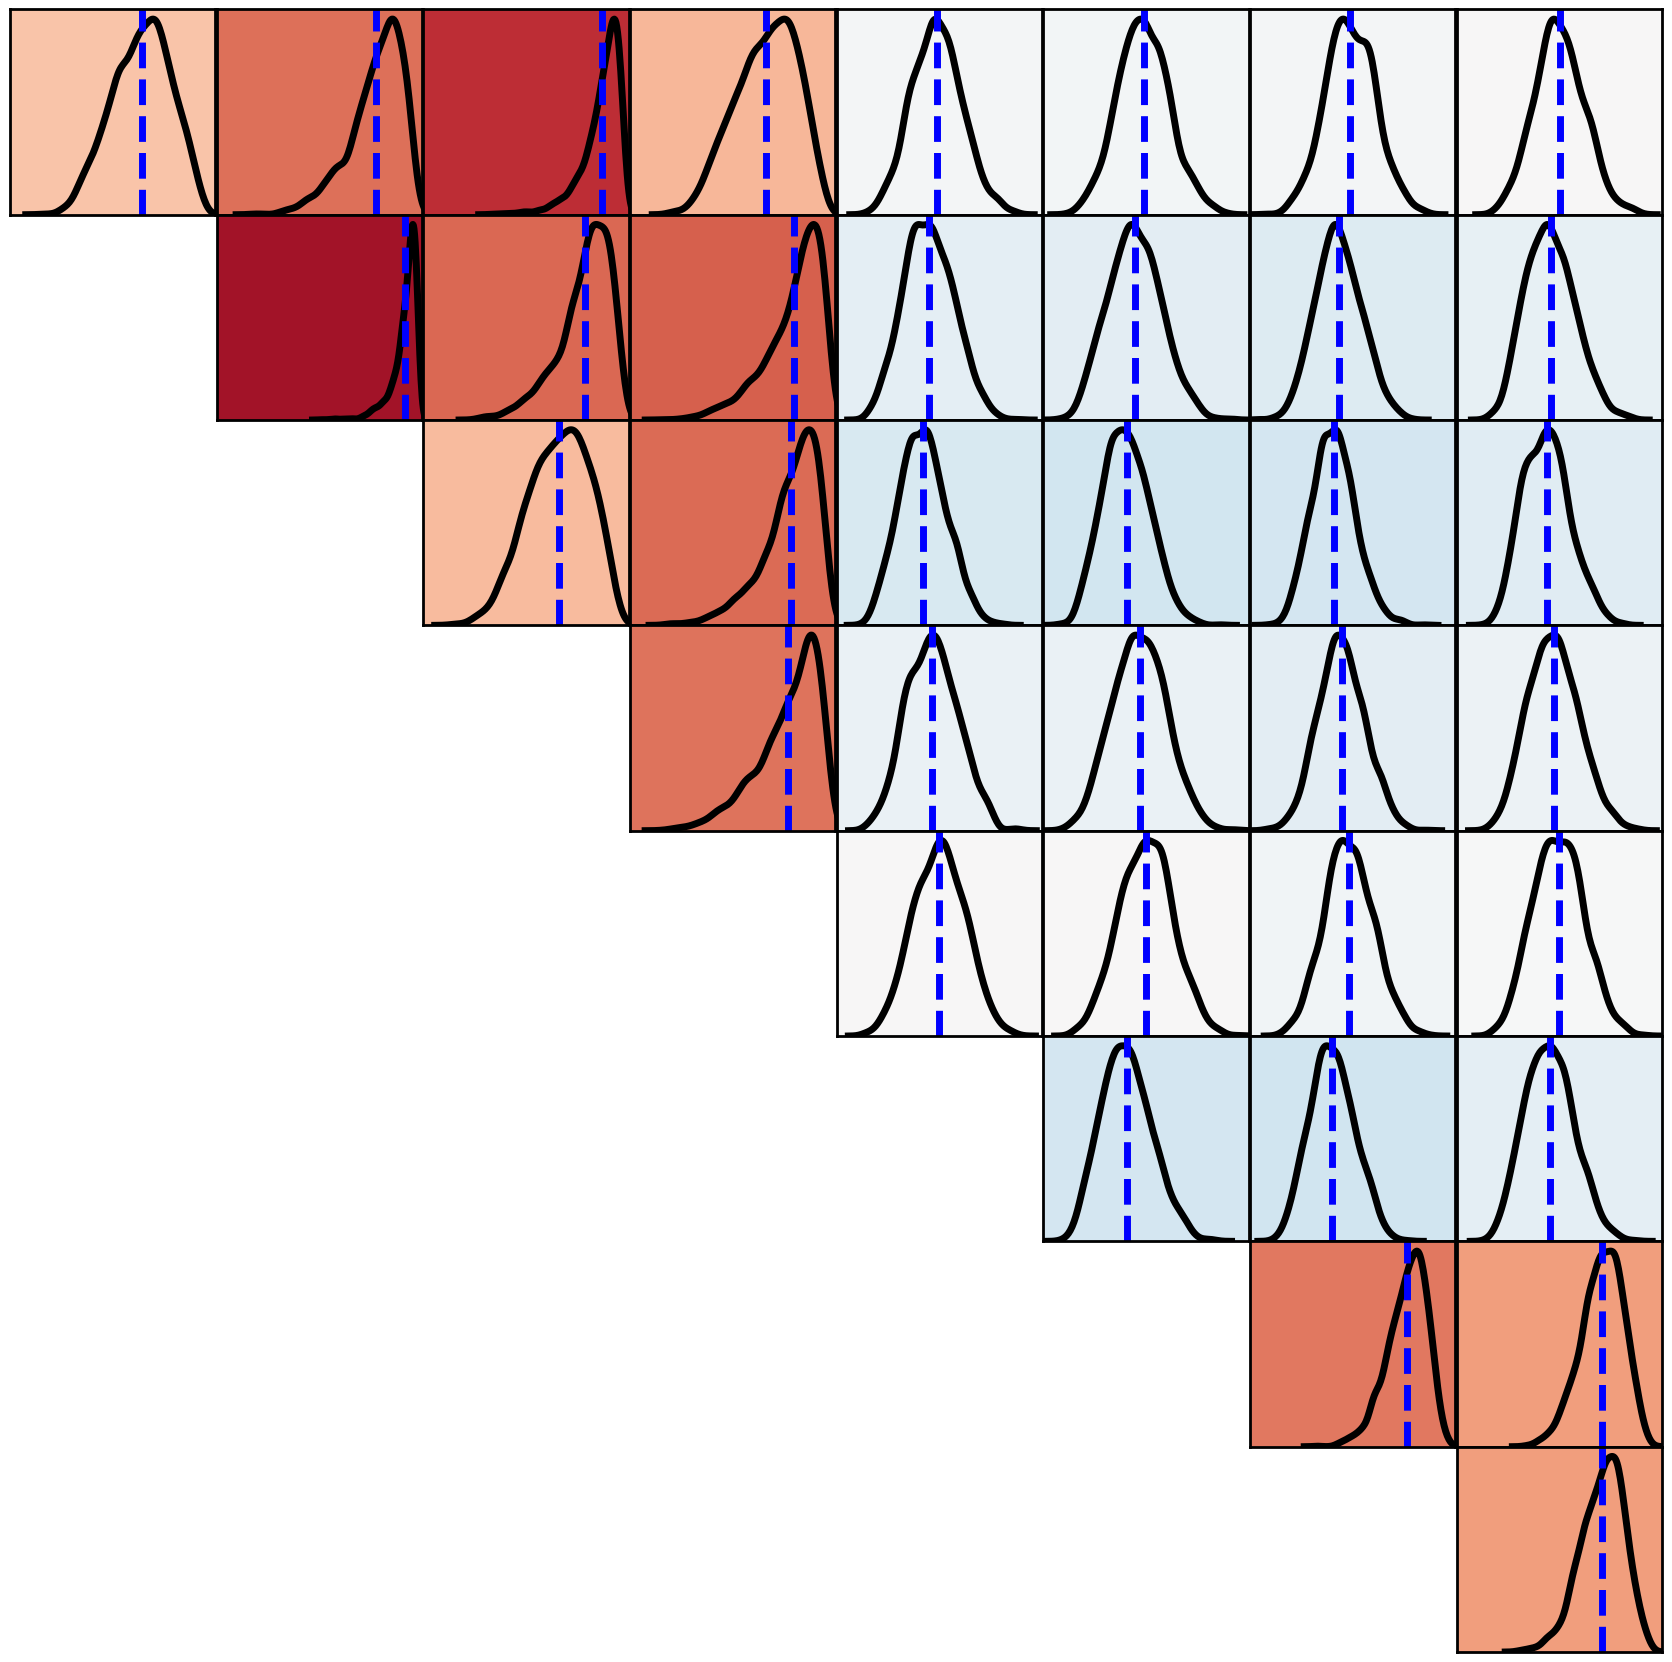

In [18]:
plot_edge_distributions(S456_connectomes, starting_roi=25, next_rois=10, avg_connectome=UKBB_S456_connectome_mu)

In [22]:
def plot_edge_distributions_full(connectomes, starting_roi_y, starting_roi_x, next_rois, avg_connectome):
    """
    Plot KDE distributions for edges between two specified ranges of ROIs.
    
    Parameters:
    -----------
    connectomes : list
        List of connectivity matrices
    starting_roi_y : int
        Starting ROI index for y-axis (0-based)
    starting_roi_x : int
        Starting ROI index for x-axis (0-based) 
    next_rois : int
        Number of subsequent ROIs to plot on each axis
    avg_connectome : numpy.ndarray
        Population average connectome matrix
    """
    # Convert to numpy array and subset
    connectome_array = np.array(connectomes)
    n_subjects = len(connectome_array)
    
    # Calculate ending ROI indices
    end_roi_y = starting_roi_y + next_rois
    end_roi_x = starting_roi_x + next_rois
    
    # First plot the subsetted connectome
    subset_connectome = avg_connectome[starting_roi_y:end_roi_y, starting_roi_x:end_roi_x]
    
    plt.figure(figsize=(12, 10), dpi=200)
    plt.imshow(subset_connectome, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
    plt.colorbar()
    plt.title(f'Average Cortical Connectome Subset\n(ROIs {starting_roi_y}-{end_roi_y-1} × {starting_roi_x}-{end_roi_x-1})')
    
    # Set integer ticks
    plt.xticks(range(0, next_rois, 5), range(starting_roi_x, end_roi_x, 5))
    plt.yticks(range(0, next_rois, 5), range(starting_roi_y, end_roi_y, 5))
    
    plt.show()
    
    # KDE part
    # Create figure with subplots for all connections between the two ranges
    n_rows = next_rois
    n_cols = next_rois
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 24))
    
    # Get max possible range from population average for consistent scaling
    max_abs_val = np.max(np.abs(avg_connectome))
    x_range = (-max_abs_val, max_abs_val)
    
    # Plot KDE for each edge between the two ranges
    for i in range(starting_roi_y, end_roi_y):
        for j in range(starting_roi_x, end_roi_x):
            # Get row and column index in subplot grid
            row = i - starting_roi_y
            col = j - starting_roi_x
            
            # Get distribution of values for this edge across subjects
            edge_values = connectome_array[:, i, j]
            
            # Get average value for background color
            avg_value = avg_connectome[i, j]
            
            # Set background color based on average value
            axes[row, col].set_facecolor(plt.cm.RdBu_r((avg_value + 1) / 2))
            
            # Plot KDE with thicker lines and black border
            sns.kdeplot(edge_values, ax=axes[row, col], color='black', linewidth=5)
            axes[row, col].spines['top'].set_visible(True)
            axes[row, col].spines['right'].set_visible(True)
            axes[row, col].spines['bottom'].set_visible(True)
            axes[row, col].spines['left'].set_visible(True)
            axes[row, col].spines['top'].set_color('black')
            axes[row, col].spines['right'].set_color('black')
            axes[row, col].spines['bottom'].set_color('black')
            axes[row, col].spines['left'].set_color('black')
            axes[row, col].spines['top'].set_linewidth(2)
            axes[row, col].spines['right'].set_linewidth(2)
            axes[row, col].spines['bottom'].set_linewidth(2)
            axes[row, col].spines['left'].set_linewidth(2)
            axes[row, col].set_xlim(x_range)
            
            # Make subplot square by setting aspect ratio to 'equal'
            axes[row, col].set_aspect(1.0/axes[row, col].get_data_ratio())
            
            # Add vertical line for population average with thicker line
            axes[row, col].axvline(x=avg_value, color='blue', linestyle='--', linewidth=5)
            
            # Remove all labels and ticks
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            axes[row, col].set_xlabel('')
            axes[row, col].set_ylabel('')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

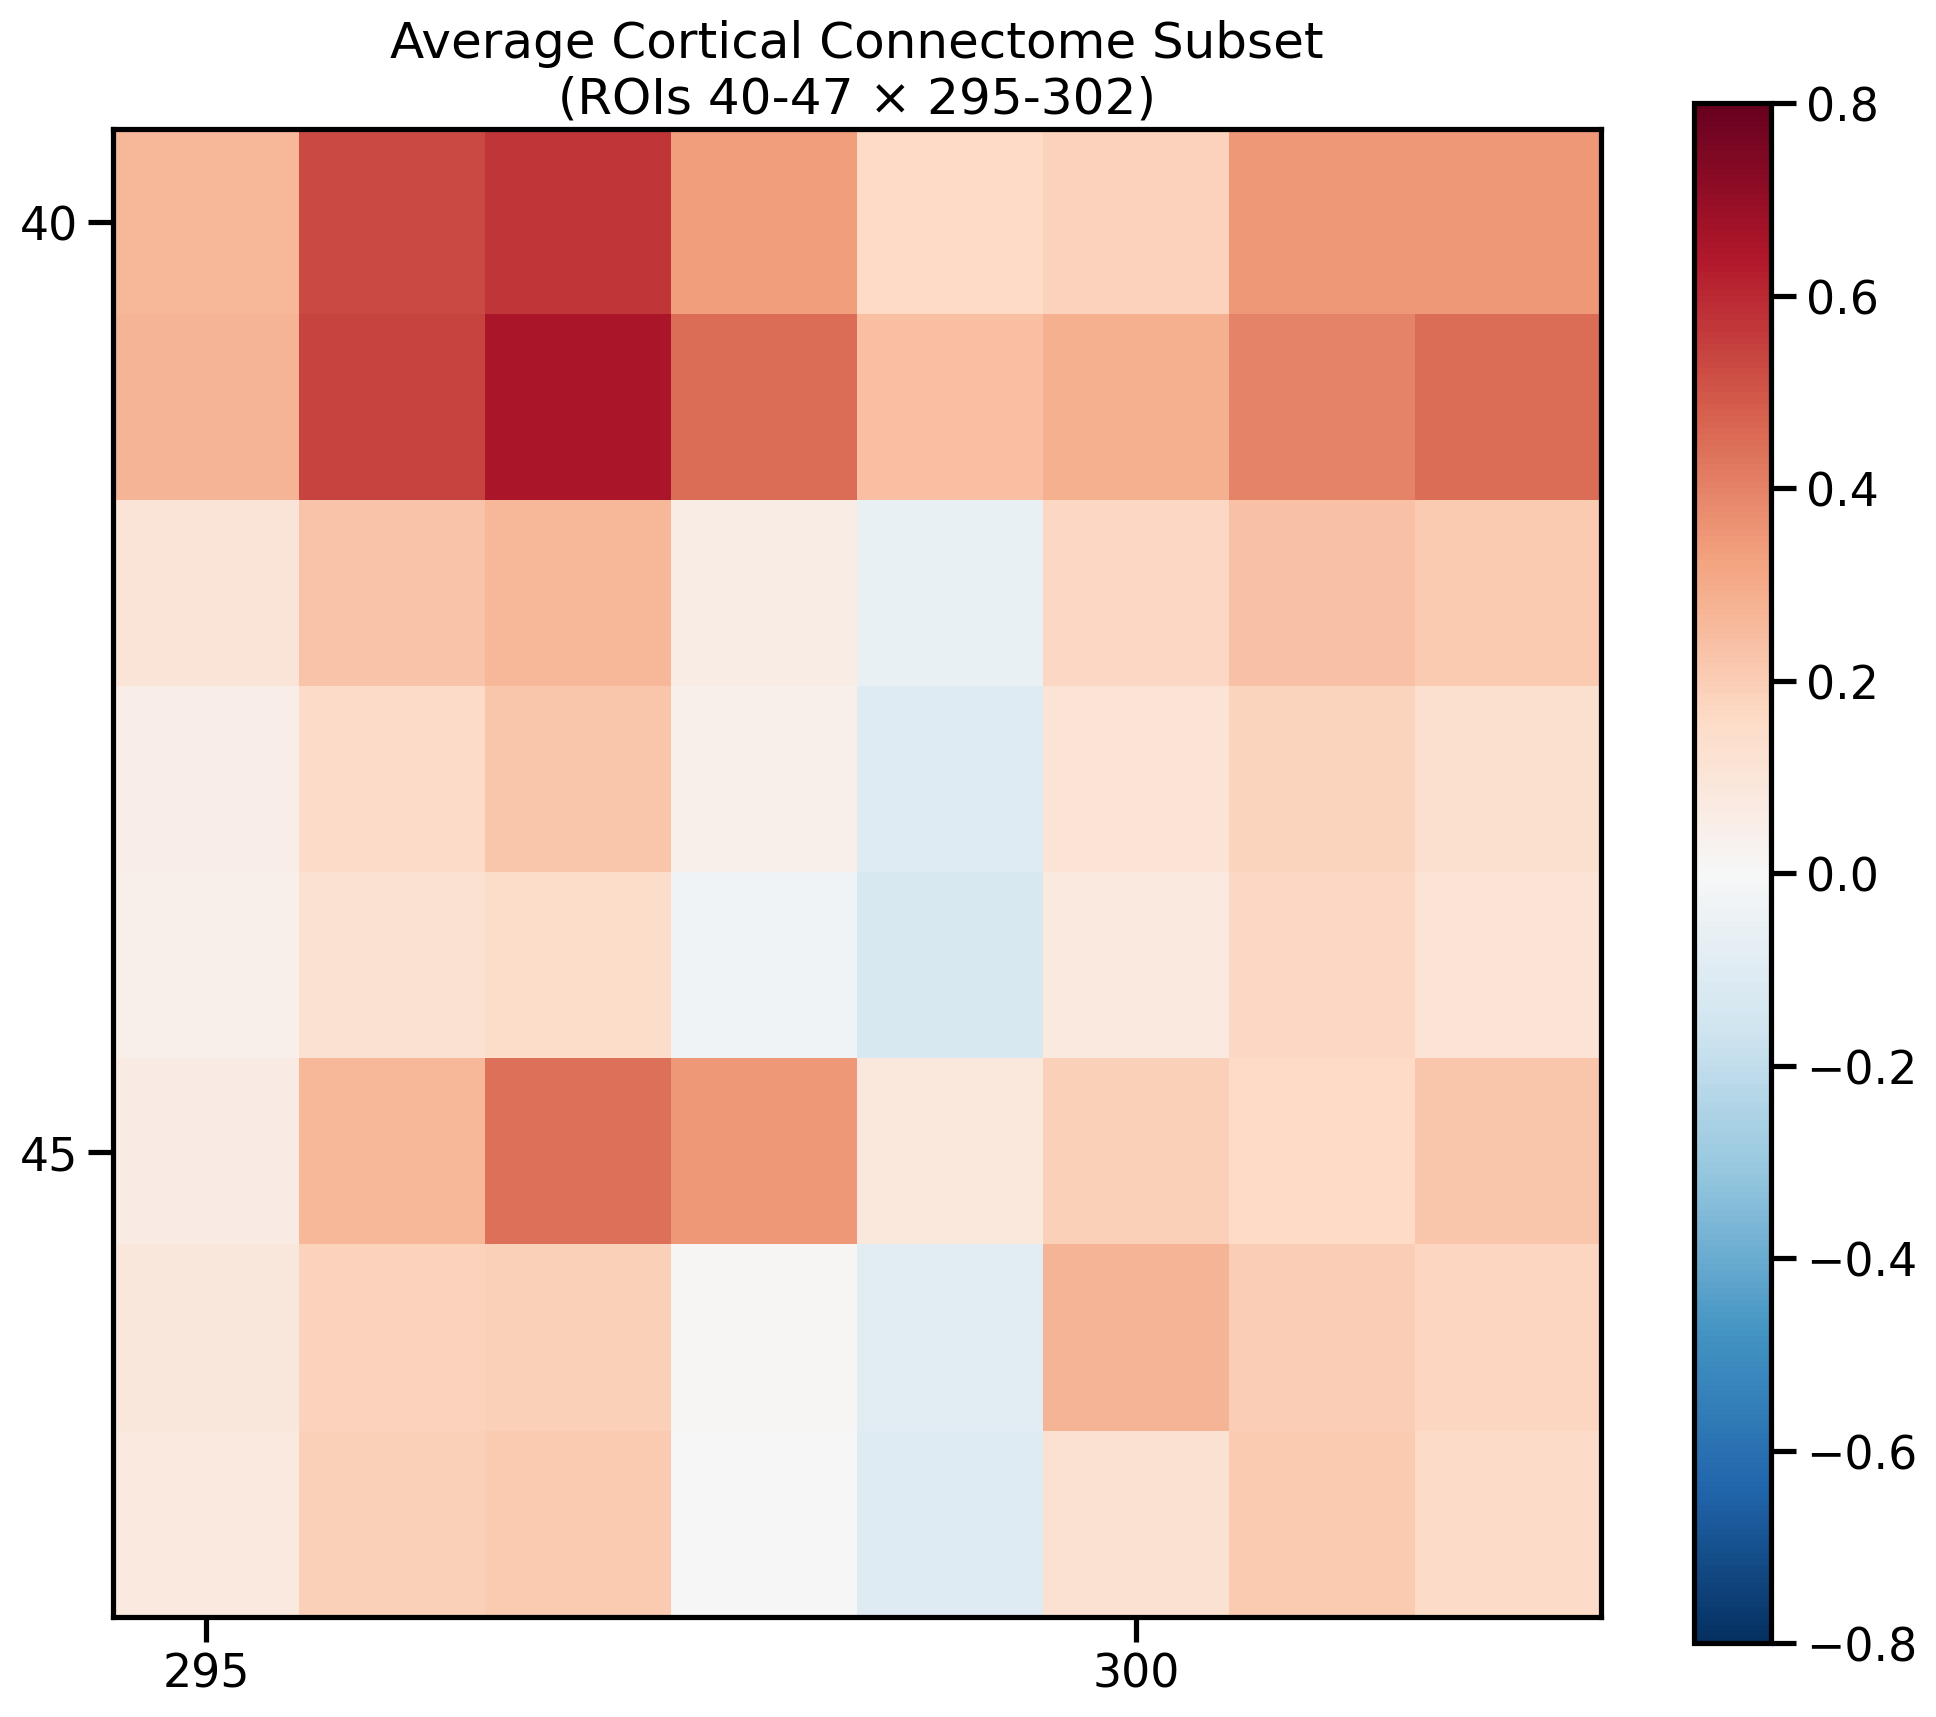

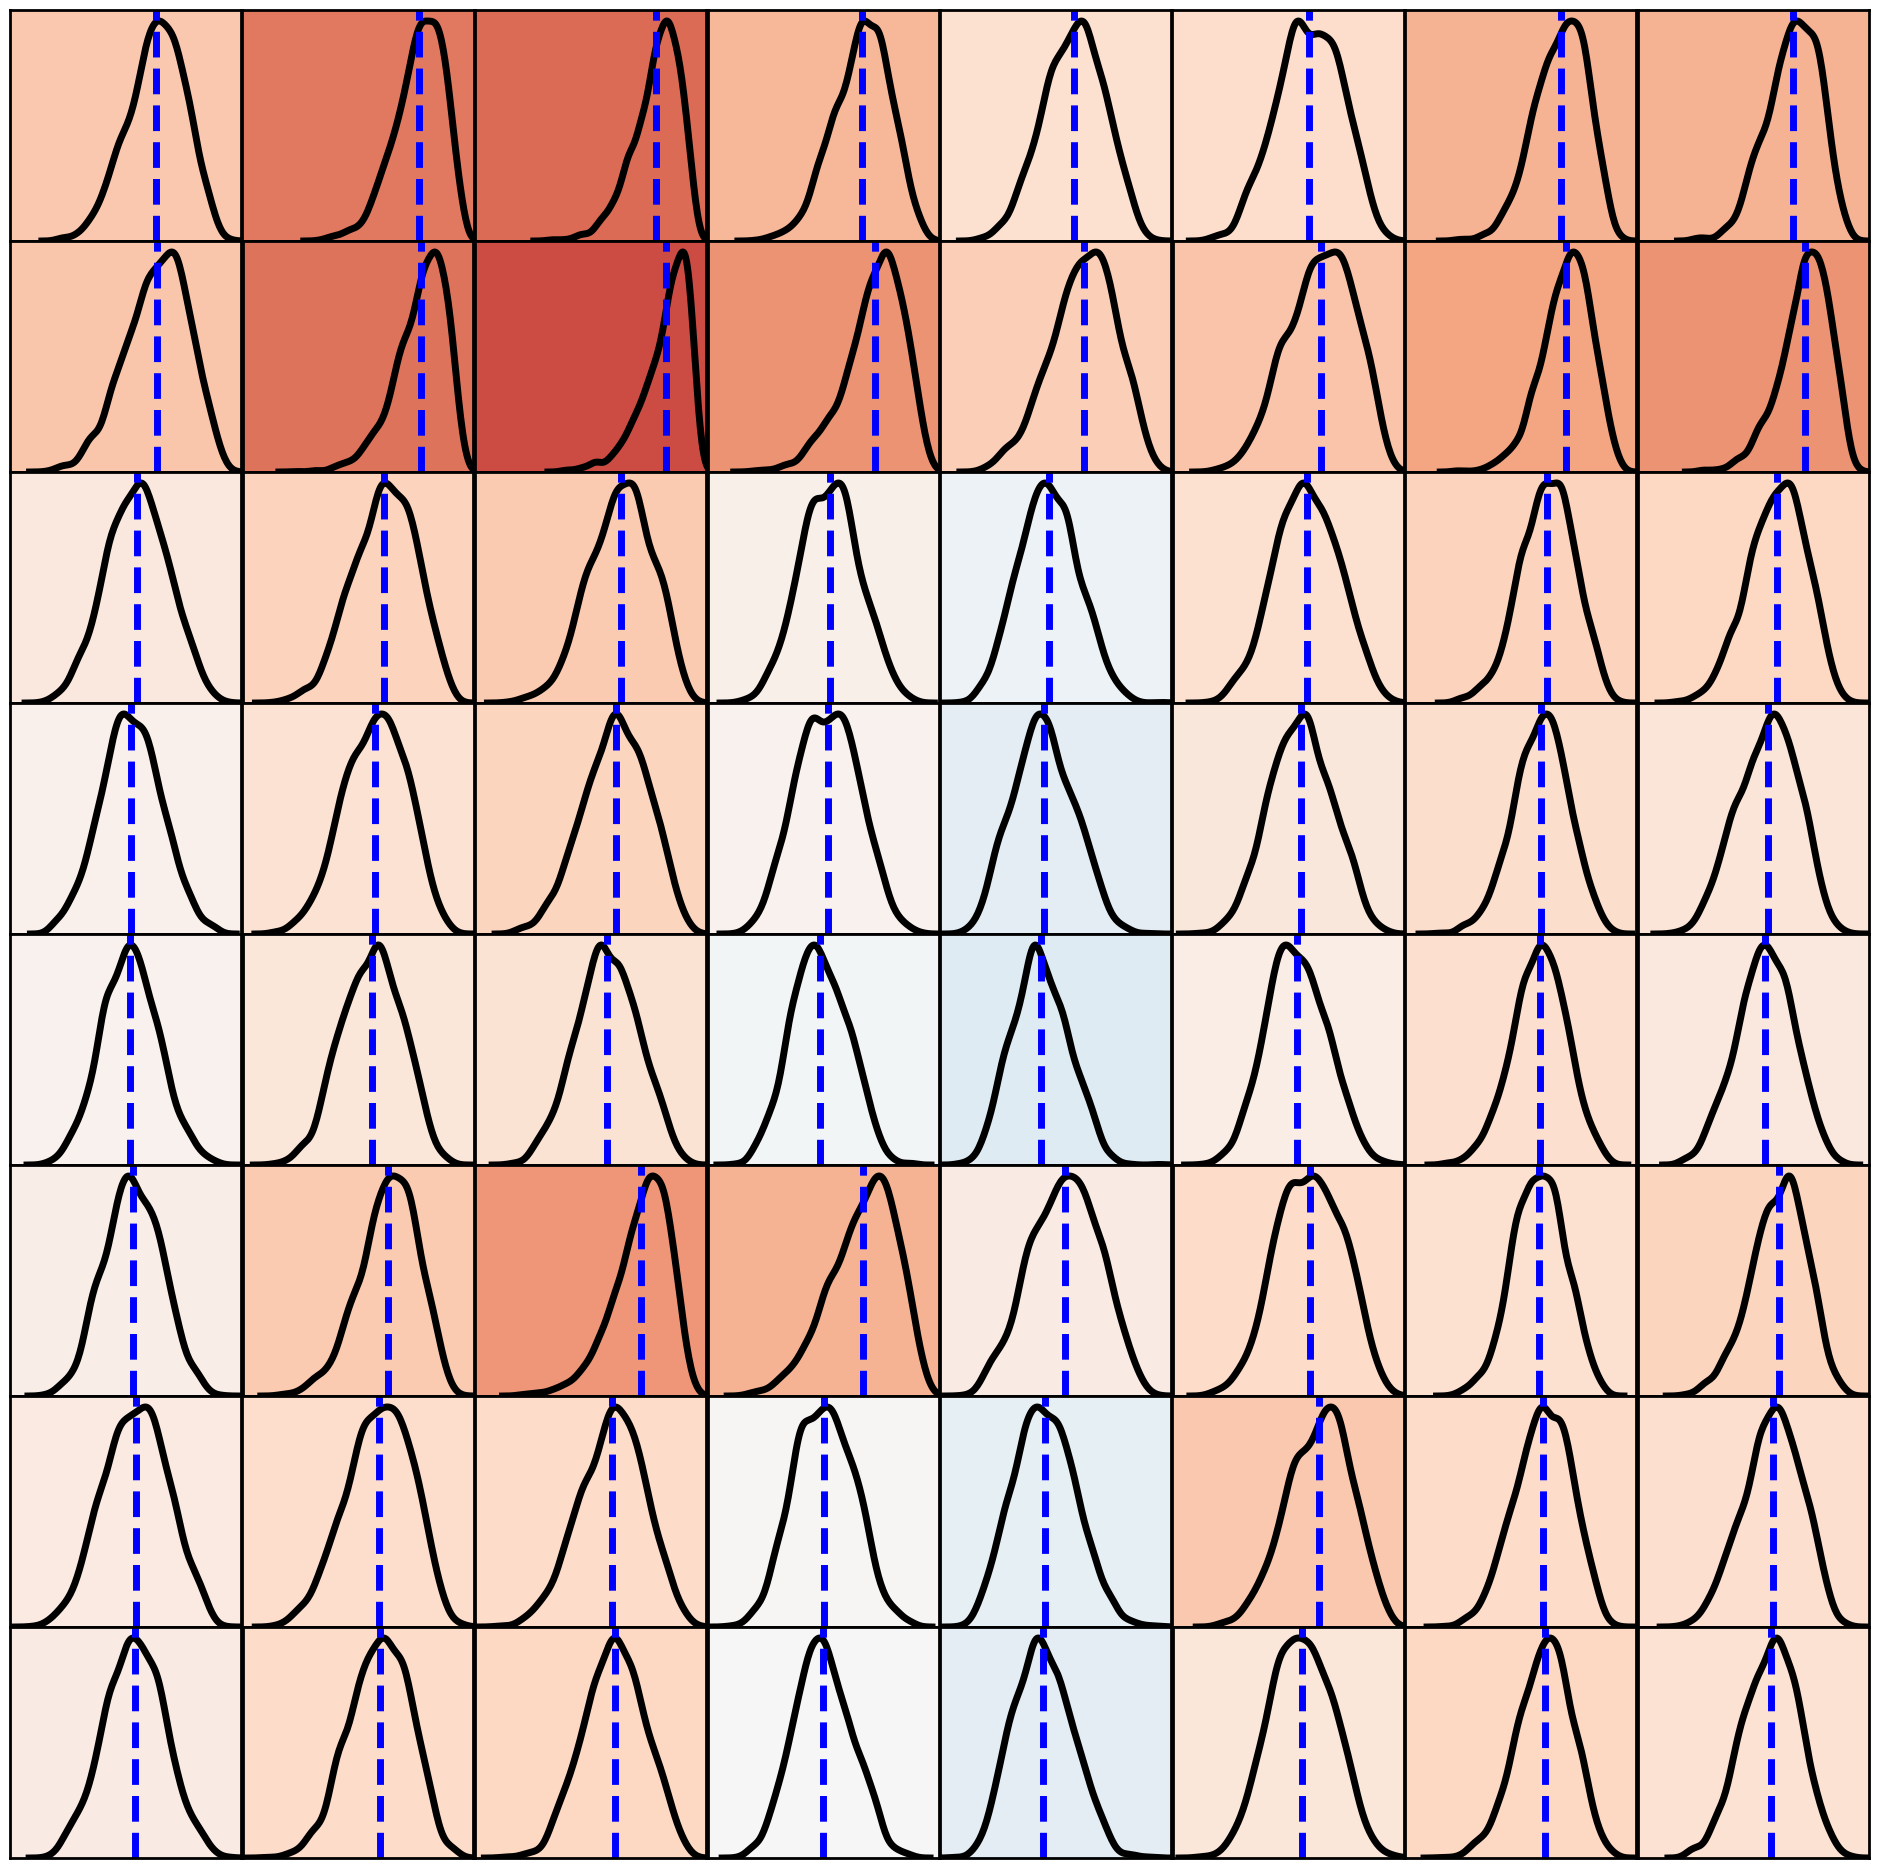

In [25]:
plot_edge_distributions_full(S456_connectomes, 40, 295, 8, UKBB_S456_connectome_mu)